# Homework #2: Music Auto Tagging (Multi-Label Classification and Metric Learning Approach)


Music auto-tagging is an important task that can be used in many musical applications such as music search or recommender systems. 

Two central methods for representation learning include deep metric learning and classification, both having the same goal of learning a representation that can generalize well across tasks.

Your mission is to build your own Neural Network model to represent audio signal. Specifically, the goals of this homework are as follows:

* Experiencing the whole pipeline of deep learning based system: data preparation, feature extraction, model training and evaluation
* Getting familiar with the Neural Network architectures for music representation
* Using Pytorch in practice

# Getting Ready

## Preparing The Dataset
We use the [magnatagatune](https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset) dataset which has been the most widely used in the music tagging task.  The MagnaTagATune dataset consists of 25k music
clips from 6,622 unique songs.

The dataset contains 30-second audio files including 189 different tags
For this homework, we are going to use a magnatagatune with 8-second audio and only 50 genres.

We use subset of magnatagatune dataset (9074 samples x 8 sec).

To make your life easier, place them in a directory as below:

```
├── annotations_final.csv
├── waveform
  ├── 1
  ├── ...
  └── d
```

In [1]:
# Download the dataset (3GB)
# %%capture
!wget http://mi.soi.city.ac.uk/datasets/magnatagatune/annotations_final.csv
!gdown --id 1f_kUF9nTLFI0pJaZxm6YNt4t_J6-Q-dg
!tar -xvf gct634.tar.gz

# if you have error, data downloads with url, and upload to google drive and then modify the path.
import os
from google.colab import drive
drive.mount('/content/drive')

# you need to change your own dir
!mv "./drive/MyDrive/Colab Notebooks/gct634.tar.gz" "."
!tar -xvf gct634.tar.gz

--2021-10-27 05:03:11--  http://mi.soi.city.ac.uk/datasets/magnatagatune/annotations_final.csv
Resolving mi.soi.city.ac.uk (mi.soi.city.ac.uk)... 138.40.249.126
Connecting to mi.soi.city.ac.uk (mi.soi.city.ac.uk)|138.40.249.126|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://mirg.city.ac.uk/datasets/magnatagatune/annotations_final.csv [following]
--2021-10-27 05:03:12--  https://mirg.city.ac.uk/datasets/magnatagatune/annotations_final.csv
Resolving mirg.city.ac.uk (mirg.city.ac.uk)... 138.40.249.131
Connecting to mirg.city.ac.uk (mirg.city.ac.uk)|138.40.249.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21517373 (21M) [text/csv]
Saving to: ‘annotations_final.csv’

annotations_final.c   8%[>                   ]   1.84M   572KB/s    eta 35s    ^C
/bin/bash: gdown: command not found
tar: gct634.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


ModuleNotFoundError: No module named 'google.colab'

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Importing Packages

In [2]:
import warnings
import multiprocessing
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import os
import torchaudio
import torch
import torch.nn as nn
from sklearn import metrics

from tqdm.notebook import tqdm
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import IPython.display as ipd

import librosa

In [3]:
torch.__version__

'1.10.0+cu102'

## Enabling and testing the GPU

First, you'll need to enable GPUs for the Colab notebook:

- Navigate to Edit (수정) → Notebook Settings (노트 설정)
- select GPU from the Hardware Accelerator (하드웨어 가속기) drop-down

Next, we'll confirm that we can connect to the GPU with PyTorch and check versions of packages:

In [4]:
if not torch.cuda.is_available():
    raise SystemError('GPU device not found!')
print(torch.cuda.get_device_name())

TITAN X (Pascal)


If the cell above throws an error, then you should enable the GPU following the instruction above!

# Data Checking


In [5]:
# use 50 top tags
TAGS = ['guitar','classical', 'slow','techno','strings','drums','electronic','rock',
        'fast','piano','ambient','beat','violin','vocal','synth','female','indian',
        'opera','male','singing','vocals','no vocals','harpsichord','loud','quiet',
        'flute', 'woman', 'male vocal', 'no vocal', 'pop','soft','sitar', 'solo',
        'man', 'classic', 'choir', 'voice', 'new age', 'dance', 'male voice',
        'female vocal', 'beats', 'harp', 'cello', 'no voice', 'weird', 'country',
        'metal', 'female voice', 'choral']

df = pd.read_csv("./annotations_final.csv", sep="\t", index_col=0)
item = df.iloc[0]
item[item != 0] # check annotated tags

classical                                                    1
strings                                                      1
opera                                                        1
violin                                                       1
mp3_path     f/american_bach_soloists-j_s__bach_solo_cantat...
Name: 2, dtype: object

In [6]:
# filter out, un-annnotated dataset
df_filter =  df[TAGS].sum(axis=1)
use_id = df_filter[df_filter != 0].index
df = df.loc[use_id]

<AxesSubplot:>

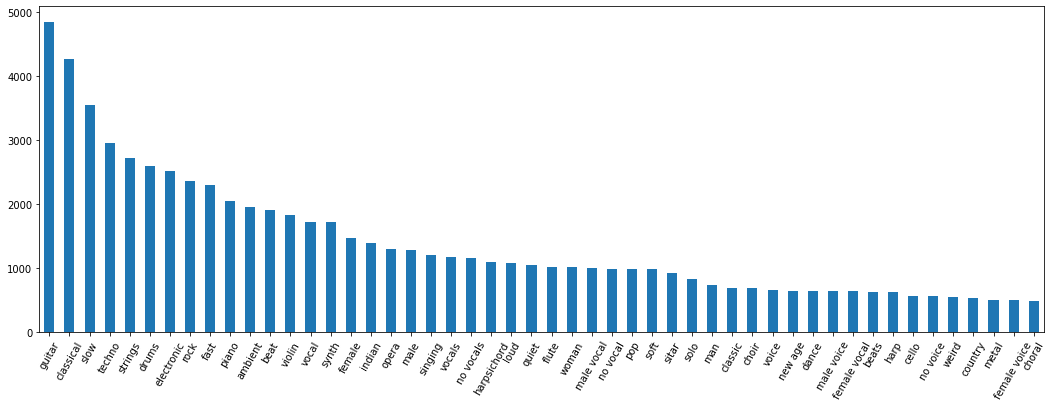

In [7]:
df[TAGS].sum().plot.bar(figsize=(18,6),rot=60) # check data distribution

# Training CNNs from Scratch

The baseline code is provided so that you can easily start the homework and also compare with your own algorithm.
The baseline model extracts mel-spectrogram and has a simple set of CNN model that includes convolutional layer, batch normalization, maxpooling and fully-connected layer.

## Data Preprocessing

In [8]:
train = []
valid = []
test = []
id_to_path = {}
for idx in range(len(df)):
    item = df.iloc[idx]
    id = item.name
    path = item['mp3_path']
    folder = path.split("/")[0]
    id_to_path[id] = path
    if folder in "012ab":
        train.append(id)# split = "train"
    elif folder == "c":    
        valid.append(id)# split = "valid"
    elif folder in "d":
        test.append(id)# split = "test"

In [9]:
total = len(train) + len(valid) + len(test)
total, len(train) / total, len(valid)/ total, len(test)/ total

(9074, 0.6839321137315406, 0.16850341635441923, 0.14756446991404013)

In [10]:
df = df[TAGS]

df_train = df.loc[train]
df_valid = df.loc[valid]
df_test = df.loc[test]

# Data processing setup.
SR = 16000
BATCH_SIZE = 16

## Check Data Augmentation works

Original


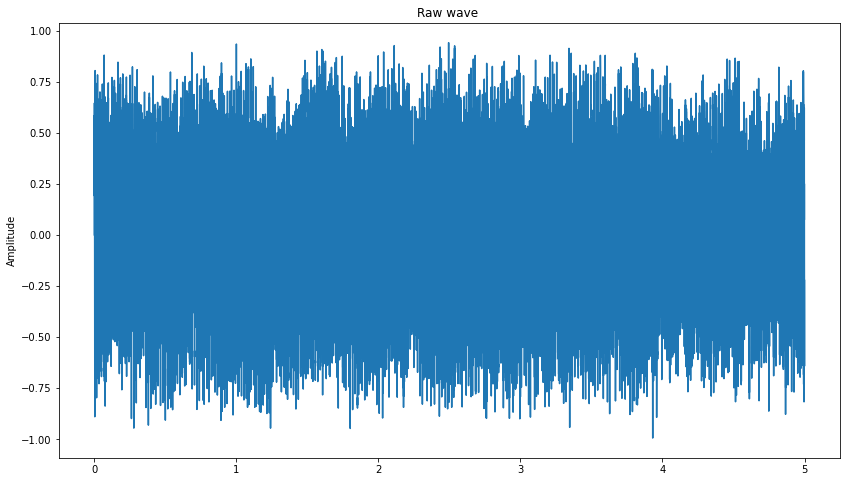

1. Add Noise


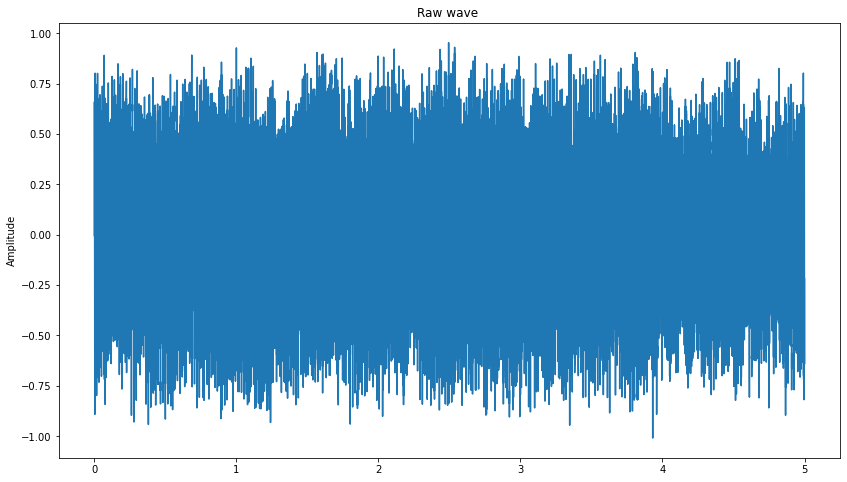

2. Shift Frames


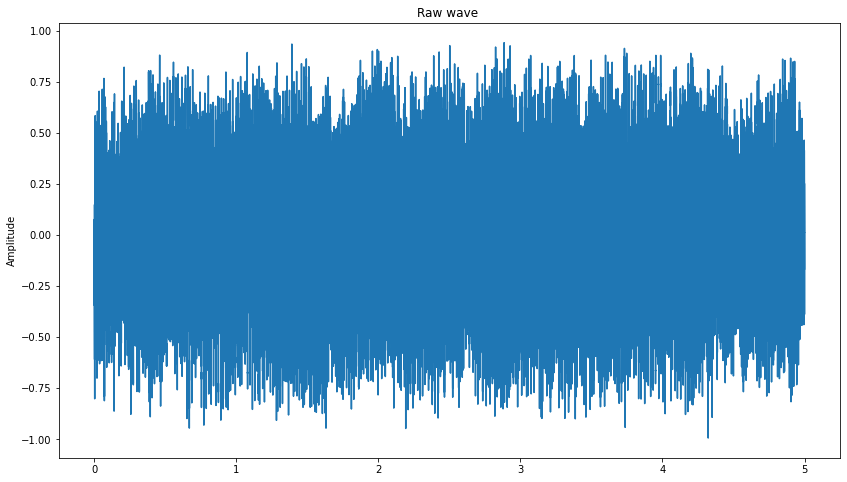

3. Stretch time axis


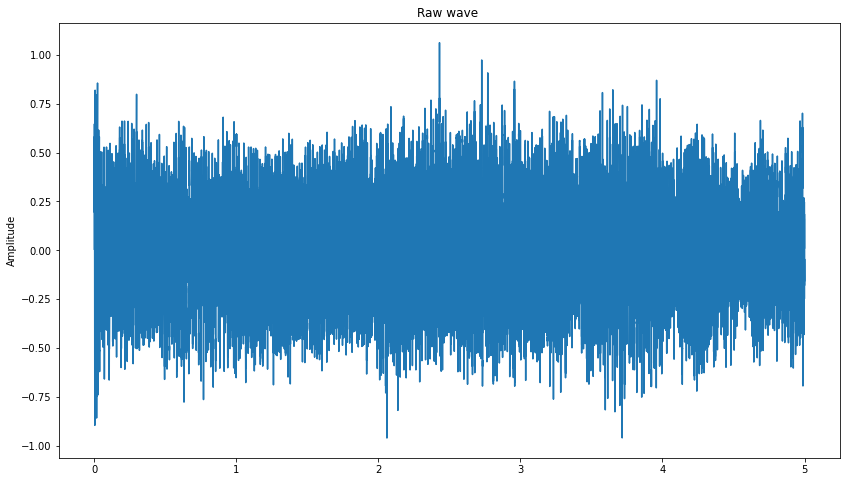

In [11]:
import matplotlib.pyplot as plt

def noise(waveform):
    white_noise = np.random.randn(len(waveform))
    return waveform + (0.01 * white_noise)
    
def shift(waveform):
    return np.roll(waveform, 10000)

def stretch(waveform, rate=1):
    input_length = len(waveform)
    waveform = librosa.effects.time_stretch(waveform, rate)
    if len(waveform)>input_length:
        waveform = waveform[:input_length]
    else:
        waveform = np.pad(data, (0, max(0, input_length - len(waveform))), "constant")
    return waveform

def check_waveform(waveform):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 5, len(waveform)), waveform)
    plt.show()
    ipd.display(ipd.Audio(waveform, rate=16000))

print("Original")
waveform = np.load("./waveform/0/williamson-a_few_things_to_hear_before_we_all_blow_up-01-2_percent_er-88-117.npy")
check_waveform(waveform)

# Noise
print("1. Add Noise")
output = noise(waveform)
check_waveform(output)

# Shift
print("2. Shift Frames")
output = shift(waveform)
check_waveform(output)

# Stretch
print("3. Stretch time axis")
output = stretch(waveform, 0.9)
check_waveform(output)


## Dataset & DataLoader

In [170]:
class AudioDataset(Dataset):
    def __init__(self, 
                 paths, 
                 input_length, 
                 binary, 
                 id_to_path, 
                 split, 
                 aug_option='None',
                 stretch_rate=0.85):
        """
        Args:
          paths (str): path to load dataset from
          input_length (int): sample_rate x duration (second) 
          binary (Pandas.DataFrame): binary matrix for audio (index: track_id, columns: tag binary)
          id_to_path (Dict): track id to audio path
          split (str): one of [TRAIN, VALID, TEST]
          
          aug_option: data augmentation option. One of ['None', 'Noise', 'Shift', 'Stretch']
          stretch_rate: stretch augmentation rate. Only for 'Stretch' option. Ignored in other options.
        """
        self.paths = paths
        self.input_length = input_length
        self.binary = binary
        self.id_to_path = id_to_path
        self.split = split
        
        self.aug_option = aug_option
        self.stretch_rate = stretch_rate
        
    def __getitem__(self, index):
        item = self.binary.iloc[index]
        waveform = self.item_to_waveform(item)
        return waveform.astype(np.float32), item.values.astype(np.float32)
    
    def item_to_waveform(self, item):
        id = item.name
        path = os.path.join(self.paths, self.id_to_path[id].replace(".mp3", ".npy")) # pre-extract waveform, for fast loader
        waveform = np.load(path)
        
        ##### ADDED: Data Augmentation #####
        if self.aug_option == 'Noise':
            white_noise = np.random.randn(len(waveform))
            waveform = waveform + (0.01 * white_noise)
        elif self.aug_option == 'Shift':
            waveform = np.roll(waveform, 10000)
        elif self.aug_option == 'Stretch':
            origin_len = len(waveform)
            waveform = librosa.effects.time_stretch(waveform, self.stretch_rate)
            if len(waveform)>origin_len:
                waveform = waveform[:origin_len]
            else:
                waveform = np.pad(waveform, (0, max(0, origin_len - len(waveform))), "constant")
        ####################################
        
        if self.split in ['TRAIN','VALID']:
            random_idx = np.random.randint(low=0, high=int(waveform.shape[0] - self.input_length))
            waveform = waveform[random_idx:random_idx+self.input_length] # extract input
            audio = np.expand_dims(waveform, axis = 0)# 1 x samples
        elif self.split == 'TEST':
            chunk_number = waveform.shape[0] // self.input_length
            chunk = np.zeros((chunk_number, self.input_length))
            for idx in range(chunk.shape[0]):
                chunk[idx] = waveform[idx * input_length:(idx+1) * input_length]
            audio = chunk
        return audio
    
    def __len__(self):
        return len(self.binary)

### Load Data (+ Data Augmentation)
Code changed slightly for data augmentation

In [173]:
data_augmentation = False

In [174]:
BATCH_SIZE = 16
num_workers = 0
sample_rate = 16000
duration = 3
input_length =  sample_rate * duration
data_path = "./waveform"
tr_data = AudioDataset(data_path, input_length, df_train, id_to_path, 'TRAIN')
va_data = AudioDataset(data_path, input_length, df_valid, id_to_path, 'VALID')
te_data = AudioDataset(data_path, input_length, df_test, id_to_path, 'TEST')

# ADDED: Data Augmentation
origin_data_num = len(df_train)
if data_augmentation:
    aug_data_num = int(origin_data_num / 2)
    noised_data = AudioDataset(data_path, input_length, df_train.sample(aug_data_num), id_to_path, 'TRAIN', 'Noise')
    shifted_data = AudioDataset(data_path, input_length, df_train.sample(aug_data_num), id_to_path, 'TRAIN', 'Shift')
    stretched_data = (AudioDataset(data_path, input_length, df_train.sample(aug_data_num), id_to_path, 'TRAIN', 'Stretch', stretch_rate=0.9) 
                      + AudioDataset(data_path, input_length, df_train.sample(aug_data_num), id_to_path, 'TRAIN', 'Stretch', stretch_rate=1.1))
    tr_data = tr_data + noised_data + shifted_data + stretched_data
    print("Data Augmentation Peformed = (", origin_data_num, " -> ", len(tr_data), ")")
else:
    print("Only Use Original Data = (", origin_data_num, ")")

loader_train = DataLoader(tr_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, drop_last=True)
loader_valid = DataLoader(va_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, drop_last=False)
loader_test = DataLoader(te_data, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False) # for chunk inference

Only Use Original Data = ( 6206 )


### Extract Multi-Channel Log Spectogram

In [175]:
def extract_spectograms(x,
                        sampling_rate=16000,
                        n_fft=512):
    num_channels = 3
    window_sizes = [10, 20, 30]
    hop_sizes = [10, 20, 30]

    specs = []
    for i in range(num_channels):
        window_legth = int(round(window_sizes[i]*sampling_rate/1000))
        hop_length = int (round(hop_sizes[i]*sampling_rate/1000))

        spec = torchaudio.transforms.MelSpectrogram(sample_rate=sampling_rate,
                                                    n_fft=n_fft,
                                                    win_length=window_legth,
                                                    hop_length=hop_length)(x)
        eps = 1e-6 # prevent inf
        spec = torch.log(spec + eps)
        spec = torch.nn.functional.interpolate(spec, size=(128, 101))
        specs.append(spec)
        
    return torch.cat(specs, dim=1)

## Training a baseline
The table below shows the architecture of the baseline.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x 16000 * sec,    | batch x channel x samples |
| mel_spec       | B x 96 x 188    | batch x freq x time|
| conv + maxpool | B x 32 x 64    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 22    | kernel_size=3, stride=1 |
| conv + maxpool | B x 32 x 8     | kernel_size=3 stride=1 |
| global_avgpool | B x 32 x 1     | -                       |
| classifier     | B x 50         | -                       |

The class below is an implementation of it:

In [59]:
import torch.nn as nn

class Baseline(nn.Module):
    def __init__(self,
                 sample_rate=16000,
                 n_fft=512,
                 f_min=0.0,
                 f_max=8000.0,
                 n_mels=96,
                 n_class=50):
        """
        Args:
          sample_rate (int): path to load dataset from
          n_fft (int): number of samples for fft
          f_min (float): min freq
          f_max (float): max freq
          n_mels (float): number of mel bin
          n_class (int): number of class
        """
        super(Baseline, self).__init__()
        # Spectrogram
        self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                         n_fft=n_fft,
                                                         f_min=f_min,
                                                         f_max=f_max,
                                                         n_mels=n_mels)
        self.to_db = torchaudio.transforms.AmplitudeToDB()
        self.spec_bn = nn.BatchNorm2d(1)

        self.conv0 = nn.Sequential(
            nn.Conv1d(n_mels, out_channels=32, kernel_size=3, stride=1, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3))

        self.conv1 = nn.Sequential(
            nn.Conv1d(32, out_channels=32, kernel_size=3, stride=1, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3))

        self.conv2 = nn.Sequential(
            nn.Conv1d(32, out_channels=32, kernel_size=3, stride=1, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=3))
        
        # Aggregate features over temporal dimension.
        self.final_pool = nn.AdaptiveAvgPool1d(1)
        # Predict tag using the aggregated features.
        self.linear = nn.Linear(32, n_class)
        
        
    def forward(self, x):
        x = self.spec(x)
        x = self.to_db(x)
        x = self.spec_bn(x)
        x = x.squeeze(1) # for 1D conv
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.final_pool(x)
        x = self.linear(x.squeeze(-1))
        x = nn.Sigmoid()(x) # for binary cross entropy loss
        return x

In [60]:
class Runner(object):
    def __init__(self, model, lr, momentum, weight_decay, sr, tags):
        """
        Args:
          model (nn.Module): pytorch model
          lr (float): learning rate
          momentum (float): momentum
          weight_decay (float): weight_decay
          sr (float): stopping rate
          tags (list): tags with index
        """
        self.optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True, weight_decay=weight_decay)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.2, patience=5, verbose=True)
        self.learning_rate = lr
        self.stopping_rate = sr
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model = model.to(self.device)
        self.criterion = torch.nn.BCELoss().to(self.device)
        self.tags = tags
        
  # Running model for train, test and validation. mode: 'train' for training, 'eval' for validation and test
    def run(self, dataloader, epoch, mode='TRAIN'):
        self.model.train() if mode is 'TRAIN' else self.model.eval()
        epoch_loss = 0
        pbar = tqdm(dataloader, desc=f'{mode} Epoch {epoch:02}')  # progress bar
        for x, y in pbar:
            # Move mini-batch to the desired device.
            x = x.to(self.device)
            y = y.to(self.device)
            # Feed forward the model.
            prediction = self.model(x)
            # Compute the loss.
            loss = self.criterion(prediction, y)
            if mode is 'TRAIN':
                # Perform backward propagation to compute gradients.
                loss.backward()
                # Update the parameters.
                self.optimizer.step()
                # Reset the computed gradients.
                self.optimizer.zero_grad()

            batch_size = len(x)
            epoch_loss += batch_size * loss.item()
        epoch_loss = epoch_loss / len(dataloader.dataset)
        return epoch_loss
    
    def test(self, dataloader):
        self.model.eval()
        epoch_loss = 0
        predictions = []
        labels = []
        pbar = tqdm(dataloader, desc=f'TEST')  # progress bar
        for x, y in pbar:
            x = x.to(self.device)
            y = y.to(self.device)
            x = x.transpose(1,0) # pre-batch in audio loader (chunk, 1, waveform)
            prediction = self.model(x)
            prediction = prediction.mean(dim=0, keepdim=True) # average chunk audio
            loss = self.criterion(prediction, y) 
            batch_size = len(x)
            epoch_loss += batch_size * loss.item()
            predictions.extend(prediction.detach().cpu().numpy())
            labels.extend(y.detach().cpu().numpy())
        epoch_loss = epoch_loss / len(loader_test.dataset)
        roc_aucs, tag_wise_rocaucs = self.get_auc(predictions, labels)
        return roc_aucs, epoch_loss, tag_wise_rocaucs
    
  # Early stopping function for given validation loss, you can use this part!
    def early_stop(self, loss, epoch):
        self.scheduler.step(loss, epoch)
        self.learning_rate = self.optimizer.param_groups[0]['lr']
        stop = self.learning_rate < self.stopping_rate
        return stop
    
    def get_auc(self, predictions, labels):
        roc_aucs  = metrics.roc_auc_score(labels, predictions, average='macro')
        tag_wise_predictions = np.stack(predictions).T
        tag_wise_labels = np.stack(labels).T
        tag_wise_rocaucs = {}
        for tag, logit, label in zip(self.tags, tag_wise_predictions, tag_wise_labels):
            tag_wise_rocaucs[tag] = metrics.roc_auc_score(label, logit)
        return roc_aucs, tag_wise_rocaucs

In [421]:
# Training setup.
LR = 1e-3  # learning rate
SR = 1e-5  # stopping rate
MOMENTUM = 0.9
NUM_EPOCHS = 10
WEIGHT_DECAY = 0.0  # L2 regularization weight

In [422]:
model = Baseline()
runner = Runner(model=model, lr = LR, momentum = MOMENTUM, weight_decay = WEIGHT_DECAY, sr = SR, tags=TAGS)
for epoch in range(NUM_EPOCHS):
    train_loss = runner.run(loader_train, epoch, 'TRAIN')
    valid_loss = runner.run(loader_valid, epoch, 'VALID')
    print("[Epoch %d/%d] [Train Loss: %.4f] [Valid Loss: %.4f]" %(epoch + 1, NUM_EPOCHS, train_loss, valid_loss))
    if runner.early_stop(valid_loss, epoch + 1):
        break


[Epoch 1/10] [Train Loss: 0.5872] [Valid Loss: 0.4888]



[Epoch 2/10] [Train Loss: 0.4110] [Valid Loss: 0.3575]



[Epoch 3/10] [Train Loss: 0.3137] [Valid Loss: 0.2891]



[Epoch 4/10] [Train Loss: 0.2677] [Valid Loss: 0.2585]



[Epoch 5/10] [Train Loss: 0.2457] [Valid Loss: 0.2419]



[Epoch 6/10] [Train Loss: 0.2340] [Valid Loss: 0.2339]



[Epoch 7/10] [Train Loss: 0.2271] [Valid Loss: 0.2283]



[Epoch 8/10] [Train Loss: 0.2226] [Valid Loss: 0.2235]



[Epoch 9/10] [Train Loss: 0.2193] [Valid Loss: 0.2207]



[Epoch 10/10] [Train Loss: 0.2167] [Valid Loss: 0.2173]


In [423]:
roc_aucs, epoch_loss, tag_wise_rocaucs = runner.test(loader_test)
print(f'test_loss={epoch_loss:.5f},  roc_auc={roc_aucs:.2f}%')


test_loss=0.43438,  roc_auc=0.64%


<AxesSubplot:>

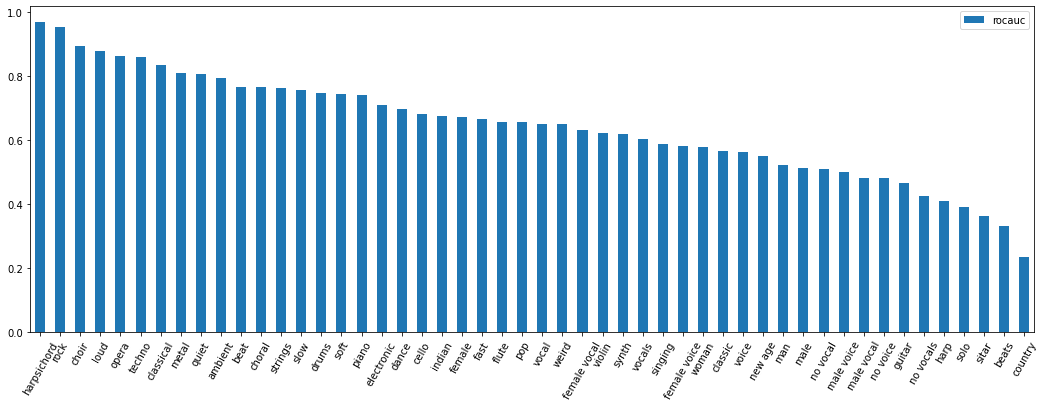

In [424]:
result_auc = pd.DataFrame([tag_wise_rocaucs[tag] for tag in TAGS], columns=['rocauc'], index=TAGS)
result_auc.sort_values(by='rocauc', ascending=False).plot.bar(figsize=(18,6),rot=60) # which tag is easy and hard task

In [425]:
def auto_tagging(waveform, model, input_length, tags, topk):
    """
    Args:
    waveform(np.array) : no channel audio (waveform, )
    model (nn.Module): pytorch model
    input_length (int): sample_rate x duration (second) 
    tags (list): list of tags
    topk (int): tagging number
    """
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = model.to(device)
    chunk_number = waveform.shape[0] // input_length
    chunk = np.zeros((chunk_number, input_length))
    for idx in range(chunk.shape[0]):
        chunk[idx] = waveform[idx * input_length:(idx+1) * input_length]
    audio_tensor = torch.from_numpy(chunk.astype(np.float32))
    predictions = model(audio_tensor.unsqueeze(1).to(device))
    logit = predictions.mean(dim=0, keepdim=False).detach().cpu().numpy()
    annotation = [tags[i] for i in logit.argsort()[::-1][:topk]]
    return annotation

In [426]:
# sample infernece id = 234
id = 224
audio_sample = df_test.loc[id]
waveform = np.load(os.path.join("./waveform",id_to_path[id].replace(".mp3",".npy")))
print("annotation tag: ",list(audio_sample[audio_sample != 0].index))
ipd.Audio(waveform, rate=16000) # load a NumPy array

annotation tag:  ['guitar', 'drums', 'rock', 'loud']


In [428]:
annotation = auto_tagging(waveform, runner.model, input_length, TAGS, 3)
print("model predict tags: ",annotation)

model predict tags:  ['techno', 'rock', 'guitar']


### [Question 1] Implement the given architecture.
Implement a 2D CNN with the architecture below, train, and report a test accuracy of the 2D CNN.

| Layer          | Output Size | Details                 |
|----------------|-------------|-------------------------|
| input          | B x 1 x sample_rate * duration,    | batch x channel (mono) x samples |
| mel_spec       | B x 1 x 96 x 188    | batch x channel (mono) x freq x time|
| conv + maxpool | B x 64 x 24 x 47    | output_channels=64, kernel_size=3, pooling=(4,4) |
| conv + maxpool | B x 128 x 8 x 15    | output_channels=128, kernel_size=3, pooling=(3,3) |
| conv + maxpool | B x 128 x  2 x 5     | output_channels=128, kernel_size=3 pooling=(3,3) |
| conv + maxpool | B x 64 x 1 x 1      | output_channels=64, kernel_size=3 pooling=(2,5)                    |
| classifier     | B x 50         | -                       |


Note: you should give appropriate paddings! 


In [429]:
import torch.nn as nn

class Conv_2d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=1, padding=1, pooling=2):
        # To do
        #========================================
        """
        Args:
          input_channels, 
          output_channels, 
          kernel_size, 
          stride, 
          padding, 
          pooling
        """
        super(Conv_2d, self).__init__()
        self.conv = nn.Conv2d(input_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.mp = nn.MaxPool2d(kernel_size=pooling, stride=pooling)
        #========================================
        
    def forward(self, x):
        out = self.mp(self.relu(self.bn(self.conv(x))))
        return out

class CNN2D(nn.Module):
    def __init__(self,
                 sample_rate=16000,
                 n_fft=512,
                 f_min=0.0,
                 f_max=8000.0,
                 n_mels=96,
                 n_class=50):
        super(CNN2D, self).__init__()

        # Spectrogram
        self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                         n_fft=n_fft,
                                                         f_min=f_min,
                                                         f_max=f_max,
                                                         n_mels=n_mels)
        self.to_db = torchaudio.transforms.AmplitudeToDB()
        self.spec_bn = nn.BatchNorm2d(1)
        # To do
        #========================================
        self.layer1 = Conv_2d(1, 64, pooling=(4,4))
        self.layer2 = Conv_2d(64, 128, pooling=(3,3))
        self.layer3 = Conv_2d(128, 128, pooling=(3,3))
        self.layer4 = Conv_2d(128, 64, pooling=(2,5))
        #========================================
        self.linear = nn.Linear(64, n_class)
        
    def forward(self, x):
        x = self.spec(x)
        x = self.to_db(x)
        x = self.spec_bn(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = nn.Sigmoid()(x) # for binary cross entropy loss
        return x

In [430]:
# Training setup.
LR = 1e-3  # learning rate
SR = 1e-5  # stopping rate
MOMENTUM = 0.9
NUM_EPOCHS = 10
WEIGHT_DECAY = 0.0  # L2 regularization weight

In [431]:
model = CNN2D()
runner = Runner(model=model, lr = LR, momentum = MOMENTUM, weight_decay = WEIGHT_DECAY, sr = SR, tags=TAGS)
for epoch in range(NUM_EPOCHS):
    train_loss = runner.run(loader_train, epoch, 'TRAIN')
    valid_loss = runner.run(loader_valid, epoch, 'VALID')
    print("[Epoch %d/%d] [Train Loss: %.4f] [Valid Loss: %.4f]" %(epoch + 1, NUM_EPOCHS, train_loss, valid_loss))
    if runner.early_stop(valid_loss, epoch + 1):
        break


[Epoch 1/10] [Train Loss: 0.3613] [Valid Loss: 0.2250]



[Epoch 2/10] [Train Loss: 0.2168] [Valid Loss: 0.2122]



[Epoch 3/10] [Train Loss: 0.2092] [Valid Loss: 0.2071]



[Epoch 4/10] [Train Loss: 0.2049] [Valid Loss: 0.2039]



[Epoch 5/10] [Train Loss: 0.2018] [Valid Loss: 0.2013]



[Epoch 6/10] [Train Loss: 0.1991] [Valid Loss: 0.1980]



[Epoch 7/10] [Train Loss: 0.1971] [Valid Loss: 0.1955]



[Epoch 8/10] [Train Loss: 0.1954] [Valid Loss: 0.1944]



[Epoch 9/10] [Train Loss: 0.1932] [Valid Loss: 0.1923]



[Epoch 10/10] [Train Loss: 0.1913] [Valid Loss: 0.1909]


In [432]:
roc_aucs, epoch_loss, tag_wise_rocaucs = runner.test(loader_test)
print(f'test_loss={epoch_loss:.5f},  roc_auc={roc_aucs:.2f}%')


test_loss=0.37956,  roc_auc=0.77%


<AxesSubplot:>

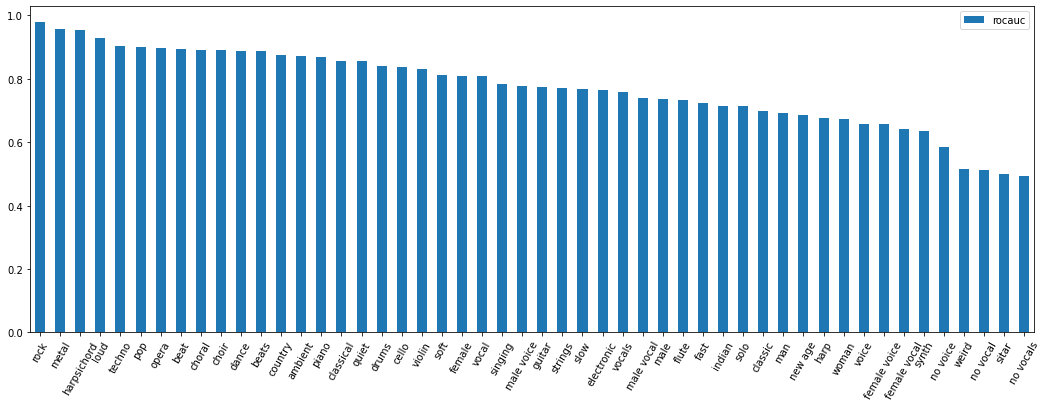

In [433]:
result_auc = pd.DataFrame([tag_wise_rocaucs[tag] for tag in TAGS], columns=['rocauc'], index=TAGS)
result_auc.sort_values(by='rocauc', ascending=False).plot.bar(figsize=(18,6),rot=60) # which tag is easy and hard task

### [Question 2] Improve the performenace.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas: 

* You can try 1D CNN or 2D CNN models and choose different model parameters:
    * Filter size
    * Pooling size
    * Stride size 
    * Number of filters
    * Model depth
    * Regularization: L2/L1 and Dropout

* You should try different hyperparameters to train the model and optimizers:
    * Learning rate
    * Model depth
    * Optimizers: SGD (with Nesterov momentum), Adam, RMSProp, ...

* You can try training a model using both mel-spectrograms and features extracted using the pre-trained models. However, end-to-end training using additional external data is prohibited. (Performance doesn't have a huge impact on grading. don't waste time)


* You can try different parameters (e.g. hop and window size) to extract mel-spectrogram or different features as input to the network (e.g. MFCC, chroma features ...). 

* You can also use ResNet or other CNNs with skip connections. 

* Furthermore, you can augment data using digital audio effects.


## Model

In [220]:
import torch.nn as nn
import torchvision
import torchvision.models as models

In [221]:
class Musical_Feature_CNN(nn.Module):
    """
    Musical Feature Learner.
    Capturing low-level musical features.
    """
    def __init__(self):
        super(Musical_Feature_CNN, self).__init__()
        
        self.spec_bn = nn.BatchNorm2d(3)
        
        self.timberal_CNN1 = nn.Conv2d(3, 204, kernel_size=(7, 38))
        self.timberal_CNN2 = nn.Conv2d(3, 204, kernel_size=(7, 67))
        self.temporal_CNN1 = nn.Conv2d(3, 51, kernel_size=(16, 1))
        self.temporal_CNN2 = nn.Conv2d(3, 51, kernel_size=(32, 1))
        self.temporal_CNN3 = nn.Conv2d(3, 51, kernel_size=(64, 1))
        
        self.timberal_mp = nn.MaxPool2d(kernel_size=(4, 3))
        self.temporal_mp = nn.MaxPool2d(kernel_size=(9, 3))
        
        self.bn = nn.BatchNorm2d(255)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.spec_bn(x)
        
        timb1 = self.timberal_CNN1(x)
        timb2 = self.timberal_CNN2(x)
        temp1 = self.temporal_CNN1(x)
        temp2 = self.temporal_CNN2(x)
        temp3 = self.temporal_CNN3(x)
        
        timbs = self.timberal_mp(torch.cat((timb1, timb2), 3))
        temps = self.temporal_mp(torch.cat((temp1, temp2, temp3), 2))    
        out = torch.cat((timbs, temps), 1)
        
        out = self.bn(out)
        out = self.relu(out)
        return out
        

In [222]:
class Residual_Block(nn.Module):
    """
    Residual Block with 2 convolutional layers and 1 residual connection.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, pooling=2):
        super(Residual_Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if (stride != 1) or (in_channels != out_channels):
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels))
        self.mp = nn.MaxPool2d(kernel_size=pooling, stride=pooling)
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        out = self.mp(out)
        return out
    

In [223]:
class Residual_CNN(nn.Module):
    """
    Representation Learner, which is consisted of 5 residual cnn layers.
    """
    def __init__(self):
        super(Residual_CNN, self).__init__()
        
        self.layer1 = Residual_Block(255, 512)
        self.layer2 = Residual_Block(512, 512)
        self.layer3 = Residual_Block(512, 256)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [224]:
class Music_Feature_Extractor(nn.Module):
    def __init__(self):
        super(Music_Feature_Extractor, self).__init__()
        self.musical_feature_layer = Musical_Feature_CNN()
        self.residual_cnn_layer = Residual_CNN()
        
    def forward(self, x):
        x = self.musical_feature_layer(x)
        x = self.residual_cnn_layer(x)
        return x

In [225]:
class Multi_Tagging_Model(nn.Module):
    def __init__(self, feature_extractor, n_class=50):
        super(Multi_Tagging_Model, self).__init__()
        self.feature_extractor = feature_extractor
        self.linear = nn.Linear(3*4*256, n_class)
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = nn.Sigmoid()(x) # for binary cross entropy loss
        return x

## Loss Function

In [226]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=3, gamma=3):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return torch.mean(F_loss)

## Runner

In [227]:
class Improved_Runner(object):
    def __init__(self, model, lr, momentum, weight_decay, sr, tags):
        """
        Args:
          model (nn.Module): pytorch model
          lr (float): learning rate
          momentum (float): momentum
          weight_decay (float): weight_decay
          sr (float): stopping rate
          tags (list): tags with index
        """
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.2, patience=5, verbose=True)
        self.learning_rate = lr
        self.stopping_rate = sr
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model = model.to(self.device)
        self.criterion = FocalLoss().to(self.device)
        self.tags = tags
        
  # Running model for train, test and validation. mode: 'train' for training, 'eval' for validation and test
    def run(self, dataloader, epoch, mode='TRAIN'):
        self.model.train() if mode == 'TRAIN' else self.model.eval()
        epoch_loss = 0
        pbar = tqdm(dataloader, desc=f'{mode} Epoch {epoch:02}')  # progress bar
        for x, y in pbar:
            # Move mini-batch to the desired device.
            x = extract_spectograms(x)
            x = x.to(self.device)
            y = y.to(self.device)
            # Feed forward the model.
            prediction = self.model(x)
            # Compute the loss.
            loss = self.criterion(prediction, y)
            if mode == 'TRAIN':
                # Perform backward propagation to compute gradients.
                loss.backward()
                # Update the parameters.
                self.optimizer.step()
                # Reset the computed gradients.
                self.optimizer.zero_grad()

            batch_size = len(x)
            epoch_loss += batch_size * loss.item()
        epoch_loss = epoch_loss / len(dataloader.dataset)
        return epoch_loss
    
    def test(self, dataloader):
        self.model.eval()
        epoch_loss = 0
        predictions = []
        labels = []
        pbar = tqdm(dataloader, desc=f'TEST')  # progress bar
        for x, y in pbar:
            x = x.transpose(0, 1)
            x = extract_spectograms(x)
            x = x.to(self.device)
            y = y.to(self.device)
            prediction = self.model(x)
            prediction = prediction.mean(dim=0, keepdim=True) # average chunk audio
            loss = self.criterion(prediction, y) 
            batch_size = len(x)
            epoch_loss += batch_size * loss.item()
            predictions.extend(prediction.detach().cpu().numpy())
            labels.extend(y.detach().cpu().numpy())
        epoch_loss = epoch_loss / len(loader_test.dataset)
        roc_aucs, tag_wise_rocaucs = self.get_auc(predictions, labels)
        return roc_aucs, epoch_loss, tag_wise_rocaucs
    
  # Early stopping function for given validation loss, you can use this part!
    def early_stop(self, loss, epoch):
        self.scheduler.step(loss, epoch)
        self.learning_rate = self.optimizer.param_groups[0]['lr']
        stop = self.learning_rate < self.stopping_rate
        return stop
    
    def get_auc(self, predictions, labels):
        roc_aucs  = metrics.roc_auc_score(labels, predictions, average='macro')
        tag_wise_predictions = np.stack(predictions).T
        tag_wise_labels = np.stack(labels).T
        tag_wise_rocaucs = {}
        for tag, logit, label in zip(self.tags, tag_wise_predictions, tag_wise_labels):
            tag_wise_rocaucs[tag] = metrics.roc_auc_score(label, logit)
        return roc_aucs, tag_wise_rocaucs

## Training & Test

In [228]:
music_feature_extractor = Music_Feature_Extractor()
multi_tagging_model = Multi_Tagging_Model(music_feature_extractor)

In [229]:
LR = 1e-3
SR = 1e-5
MOMENTUM = 0.9
NUM_EPOCHS = 30
WEIGHT_DECAY = 1e-4

In [230]:
runner = Improved_Runner(model = multi_tagging_model, lr = LR, momentum = MOMENTUM, weight_decay = WEIGHT_DECAY, sr = SR, tags=TAGS)
for epoch in range(NUM_EPOCHS):
    train_loss = runner.run(loader_train, epoch, 'TRAIN')
    valid_loss = runner.run(loader_valid, epoch, 'VALID')
    print("[Epoch %d/%d] [Train Loss: %.4f] [Valid Loss: %.4f]" %(epoch + 1, NUM_EPOCHS, train_loss, valid_loss))
    if runner.early_stop(valid_loss, epoch + 1):
        print("qquack")
        break

KeyboardInterrupt: 

In [219]:
roc_aucs, epoch_loss, tag_wise_rocaucs = runner.test(loader_test)
print(f'test_loss={epoch_loss:.5f},  roc_auc={roc_aucs:.2f}%')


test_loss=0.13454,  roc_auc=0.86%


<AxesSubplot:>

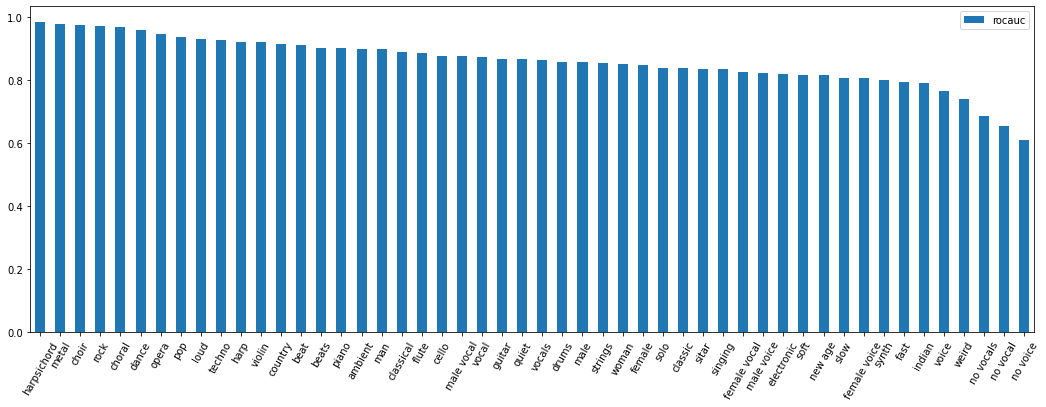

In [187]:
result_auc = pd.DataFrame([tag_wise_rocaucs[tag] for tag in TAGS], columns=['rocauc'], index=TAGS)
result_auc.sort_values(by='rocauc', ascending=False).plot.bar(figsize=(18,6),rot=60) # which tag is easy and hard task

### Save & load

In [38]:
torch.save(multi_tagging_model, './multi_tagging_model.pt')

In [168]:
multi_tagging_model = torch.load('./multi_tagging_model.pt')

# Metric Learning

Metric learning is a paradigm of representation learning, in which proximity between the representations of items is optimized to correspond to a notion of similarity. 

Compared to the classification, metric learning can leverage more flexible forms of supervision, for example, two audio clips belong to the same artist or not, or have the same tempo or not. Search and recommender systems rely on similarity between songs, artists, albums, lyrics, tags, etc. Nearest neighbor classifiers use similarity to propagate information (eg, tags) from labeled to unlabeled data.


### Dataloader

In [153]:
import random
class TripletDataset(Dataset):
    def __init__(self, paths, id_to_path, input_length, binary, tags, split):
        """
        Args:
          paths (str): path to load dataset from
          id_to_path (Dict): track id to audio path
          input_length (int): sample_rate x duration (second) 
          binary (Pandas.DataFrame): binary matrix for audio (index: track_id, columns: tag binary)
          tags(list) : list of tag
          split (str): one of [TRAIN, VALID, TEST]
        """
        self.paths = paths
        self.id_to_path = id_to_path
        self.input_length = input_length
        self.tags = tags
        self.binary = binary
        self.split = split

    def __getitem__(self, index):
        if self.split in ["TRAIN","VALID"]:
            tag = random.choice(self.tags)
            tag_binary = self.binary[tag]
            positive_tracks = tag_binary[tag_binary != 0]
            negative_tracks = tag_binary[tag_binary == 0]
            anc_id, pos_id = positive_tracks.sample(2).index
            neg_id = negative_tracks.sample(1).index[0]

            anc_waveform = self.item_to_waveform(anc_id)
            pos_waveform = self.item_to_waveform(pos_id)
            neg_waveform = self.item_to_waveform(neg_id)
            return anc_waveform, pos_waveform, neg_waveform

        elif self.split == "TEST":
            item = self.binary.iloc[index]
            id = item.name
            path = os.path.join(self.paths, self.id_to_path[id].replace(".mp3",".npy"))
            waveform = np.load(path)
            chunk_number = waveform.shape[0] // self.input_length
            chunk = np.zeros((chunk_number, self.input_length))
            for idx in range(chunk.shape[0]):
                chunk[idx] = waveform[idx * input_length:(idx+1) * input_length]
            audio = chunk.astype(np.float32)
            label = item.values.astype(np.float32)
            return audio, label

    def item_to_waveform(self, id):
        path = os.path.join(self.paths, self.id_to_path[id].replace(".mp3", ".npy")) # pre-extract waveform, for fast loader
        waveform = np.load(path) 
        random_idx = np.random.randint(low=0, high=int(waveform.shape[0] - self.input_length))
        waveform = waveform[random_idx:random_idx+self.input_length] # extract input
        audio = np.expand_dims(waveform, axis = 0)# 1 x samples
        return audio.astype(np.float32)

    def __len__(self):
        if self.split in ["TRAIN","VALID"]:
            return len(self.binary) # it is tag wise sampling, so you can increase dataset length
        elif self.split == "TEST":
            return len(self.binary)

In [154]:
df_train

guitar  classical  slow  techno  strings  drums  electronic  rock  \
clip_id                                                                      
29            0          1     0       0        0      0           0     0   
101           0          0     0       0        0      0           0     1   
105           1          0     0       0        0      0           0     1   
133           0          0     0       0        0      0           0     0   
134           0          0     1       1        0      1           1     0   
...         ...        ...   ...     ...      ...    ...         ...   ...   
58613         1          0     0       0        0      0           0     0   
58629         0          0     0       0        0      0           0     0   
58630         0          1     1       0        1      0           0     0   
58631         0          1     0       0        0      0           0     0   
58638         0          0     0       0        0      0           0     0   

         fast  piano  ...  female vocal  beats  harp  cello  no voice  weird  \
clip_id               ...                                                      
29          0      0  ...             0      0     0      0         0      0   
101         0      0  ...             0      0     0      0         0      0   
105         1      0  ...             0      0     0      0         0      0   
133         0      0  ...             0      0     0      0         0      0   
134         0      0  ...             0      0     0      0         0      1   
...       ...    ...  ...           ...    ...   ...    ...       ...    ...   
58613       0      0  ...             0      0     0      0         0      0   
58629       0      0  ...             0      0     0      0         0      0   
58630       0      0  ...             0      0     0      0         0      0   
58631       0      0  ...             0      0     1      0         0      0   
58638       0      0  ...             0      0     1      0         0      0   

         country  metal  female voice  choral  
clip_id                                        
29             0      0             0       0  
101            0      0             0       0  
105            0      0             0       0  
133            0      0             0       0  
134            0      0             0       0  
...          ...    ...           ...     ...  
58613          0      0             0       0  
58629          0      0             0       0  
58630          0      0             0       0  
58631          0      0             0       0  
58638          0      0             0       0  

[6206 rows x 50 columns]

In [155]:
tr_data = TripletDataset(data_path, id_to_path, input_length, df_train, TAGS, "TRAIN")
va_data = TripletDataset(data_path, id_to_path, input_length, df_valid, TAGS, "VALID")
te_data = TripletDataset(data_path, id_to_path, input_length, df_test, TAGS, "TEST")
loader_train = DataLoader(tr_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, drop_last=True)
loader_valid = DataLoader(va_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, drop_last=False)
loader_test = DataLoader(te_data, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

In [156]:
class LinearProjection(nn.Module):
    """
    Backbone model for linear proejction
    mel spectrogam to embedding
    """
    def __init__(self,
              sample_rate=16000,
              n_fft=512,
              f_min=0.0,
              f_max=8000.0,
              n_mels=96):
        """
        Args:
          sample_rate (int): path to load dataset from
          n_fft (int): number of samples for fft
          f_min (float): min freq
          f_max (float): max freq
          n_mels (float): number of mel bin
          n_class (int): number of class
        """
        super(LinearProjection, self).__init__()
        self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                          n_fft=n_fft,
                                                          f_min=f_min,
                                                          f_max=f_max,
                                                          n_mels=n_mels)
        self.to_db = torchaudio.transforms.AmplitudeToDB()
        self.spec_bn = nn.BatchNorm2d(1)
        self.embedding_size = 4096
        self.linear_proj = nn.Linear(n_mels * 188, self.embedding_size) # (freq * time) to embedding dim
    def forward(self, x):
        x = self.spec(x)
        x = self.to_db(x)
        x = self.spec_bn(x)
        x = x.squeeze(1)
        x = x.view(x.size(0), -1)
        embedding = self.linear_proj(x)
        return embedding

In [157]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        """
        Args:
          margin:
        """
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.relu = nn.ReLU()
    
    def forward(self, anchor, positive, negative):
        pos_sim = nn.CosineSimilarity(dim=-1)(anchor, positive)
        neg_sim = nn.CosineSimilarity(dim=-1)(anchor, negative)
#         pos_sim = nn.functional.pairwise_distance(anchor, positive)
#         neg_sim = nn.functional.pairwise_distance(anchor, negative)
        losses = self.relu(self.margin - pos_sim + neg_sim)
        return losses.mean()

### [Question 3] Implement the evaluation metric.
Implement a multi-label recall for metric learning. 
- https://arxiv.org/abs/2008.03729

If one of the top K retrieved results has the same class label as the query song, the recall@K is set to 1, otherwise it is set to 0. This process is repeated for all samples in the test set and then averaged. Our data is multi-labeled, however, so we adapt the standard single-label (multi-class) R@K metric to create a multi-label variant. Our definition is

$$
Recall@K = \frac{1}{N} \Sigma^{N}_{q=1} 
\frac{n(y^{q} \cap (\cup^{K}_{i=1}y^{i})}{n(y^{q})}
$$

where $N$ is the number of test samples, $y^{q}$ is the ground truth labels of a query, and $y^{i}$ is the ground truth labels of the top $K$ retrieved results. And, $n(·)$ denotes the number of the elements of a set. In this setup, if the set of labels of the top K retrieved results contains all the multiple labels of the query song, the recall@K is set to 1, otherwise it is set to the correct answer ratio. We report R@K when K is 1, 2, 4, and 8.

In [77]:
class Metric_Runner(object):
    def __init__(self, model, lr, momentum, weight_decay, sr):
        """
        Args:
          model (nn.Module): pytorch model
          lr (float): learning rate
          momentum (float): momentum
          weight_decay (float): weight_decay
          sr (float): stopping rate
        """
        self.optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True, weight_decay=weight_decay)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.2, patience=5, verbose=True)
        self.learning_rate = lr
        self.stopping_rate = sr
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model = model.to(self.device)
        self.criterion = TripletLoss(margin=0.4).to(self.device)
        
    # Running model for train, test and validation. mode: 'train' for training, 'eval' for validation and test
    def run(self, dataloader, epoch, mode='TRAIN'):
        self.model.train() if mode is 'TRAIN' else self.model.eval()
        
        epoch_loss = 0
        pbar = tqdm(dataloader, desc=f'{mode} Epoch {epoch:02}')  # progress bar
        for item in pbar:
            # Move mini-batch to the desired device.
            anc, pos, neg = item
            anc_emb = self.model(anc.to(self.device))
            pos_emb = self.model(pos.to(self.device))
            neg_emb = self.model(neg.to(self.device))

            # Compute the loss.
            loss = self.criterion(anc_emb, pos_emb, neg_emb)
            if mode is 'TRAIN':
                # Perform backward propagation to compute gradients.
                loss.backward()
                # Update the parameters.
                self.optimizer.step()
                # Reset the computed gradients.
                self.optimizer.zero_grad()

            batch_size = anc_emb.shape[0]
            epoch_loss += batch_size * loss.item()
        epoch_loss = epoch_loss / len(dataloader.dataset)
        return epoch_loss
    
    def test(self, dataloader):
        self.model.eval()
        epoch_loss = 0
        embeddings, labels = [], []
        pbar = tqdm(dataloader, desc=f'TEST')  # progress bar
        for waveform, label in pbar:
            waveform = waveform.transpose(1,0)
            with torch.no_grad():
                embedding = self.model(waveform.to(self.device))
            embeddings.append(embedding.mean(0,True).detach().cpu())
            labels.append(label)
        embeddings = torch.stack(embeddings).squeeze(1)
        labels = torch.stack(labels).squeeze(1)

        # calculate cosine similarity (if you use different distance metric, than you need to change this part)
        embedding_norm = embeddings / embeddings.norm(dim=-1, keepdim=True)
        sim_matrix = embedding_norm @ embedding_norm.T
        sim_matrix = sim_matrix.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        multilabel_recall = {
            "R@1" : self.multilabel_recall(sim_matrix, labels, top_k=1),
            "R@2" : self.multilabel_recall(sim_matrix, labels, top_k=2),
            "R@4" : self.multilabel_recall(sim_matrix, labels, top_k=4),
            "R@8" : self.multilabel_recall(sim_matrix, labels, top_k=8),
        }
        return multilabel_recall
    
    def multilabel_recall(self, sim_matrix, binary_labels, top_k):
        # =======================
        ## To-do
        data_num = len(sim_matrix)
        recall = 0
        for query_idx in range(data_num):
            query = sim_matrix[query_idx]
            sorted_idx = np.argsort(query)[::-1][1:top_k+1]
            y_q = binary_labels[query_idx]
            y_i = np.logical_or.reduce(([binary_labels[pred_idx] for pred_idx in sorted_idx]))
            recall += (np.sum(np.logical_and(y_q, y_i)) / np.sum(y_q))
        recall /= data_num
        return recall
        # =======================
        
    # Early stopping function for given validation loss
    def early_stop(self, loss, epoch):
        self.scheduler.step(loss, epoch)
        self.learning_rate = self.optimizer.param_groups[0]['lr']
        stop = self.learning_rate < self.stopping_rate
        return stop

In [78]:
NUM_EPOCHS = 3
model = LinearProjection()
runner = Metric_Runner(model=model, lr = LR, momentum = MOMENTUM, weight_decay = WEIGHT_DECAY, sr = SR)
for epoch in range(NUM_EPOCHS):
    train_loss = runner.run(loader_train, epoch, 'TRAIN')
    valid_loss = runner.run(loader_valid, epoch, 'VALID')
    print("[Epoch %d/%d] [Train Loss: %.4f] [Valid Loss: %.4f]" %(epoch + 1, NUM_EPOCHS, train_loss, valid_loss))
    if runner.early_stop(valid_loss, epoch + 1):
        break


[Epoch 1/3] [Train Loss: 0.3412] [Valid Loss: 0.3201]



[Epoch 2/3] [Train Loss: 0.3344] [Valid Loss: 0.3247]



[Epoch 3/3] [Train Loss: 0.3419] [Valid Loss: 0.3275]


In [79]:
multilabel_recall = runner.test(loader_test)

In [80]:
multilabel_recall

{'R@1': 0.38478293551109044,
 'R@2': 0.514525334428247,
 'R@4': 0.6402500681626896,
 'R@8': 0.7587732655693812}

### [Question 4] Improve the performenace.
Now it is your turn. You should improve the baseline code with your own algorithm. There are many ways to improve it. The followings are possible ideas: 

* Change backbone model
  - https://arxiv.org/abs/1609.04243
  - https://arxiv.org/abs/1711.02520
  - https://arxiv.org/abs/2006.00751
* Change distance mesure
  - Euclidean distance
  - Cosine distance
* Change positive negative sampling
  - Tag based sampling
  - Timbre, Beat based sampling
  - Latent Space based sampling (SVD or Word Embedding)
  - Instance based sampling

## Check the triplet sampling strategy works

In [84]:
import matplotlib.pyplot as plt

def item_to_waveform(id):
    path = os.path.join(data_path, id_to_path[id].replace(".mp3", ".npy")) # pre-extract waveform, for fast loader
    waveform = np.load(path) 
    random_idx = np.random.randint(low=0, high=int(waveform.shape[0] - input_length))
    waveform = waveform[random_idx:random_idx+input_length] # extract input
    audio = np.expand_dims(waveform, axis = 0)# 1 x samples
    return audio.astype(np.float32)
        
def get_tag_names(id):
    item = binary.loc[id]
    return list(item[item != 0].index)

def plot_time_series(waveform):
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 5, len(waveform)), waveform)
    plt.show()

def check_triplet_waveforms(anc, pos, neg):
    triplet_info = [('Anchor', anc), ('Positive', pos), ('Negative', neg)]
    for i, (name, (tag, clip_id)) in enumerate(triplet_info):
        print(i+1, ".", name, "tag: ", tag)
        waveform = np.load(os.path.join("./waveform",id_to_path[clip_id].replace(".mp3",".npy")))
        plot_time_series(waveform)
        ipd.display(ipd.Audio(waveform, rate=16000))

In [89]:
tags = TAGS
binary = df_train
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

tag = random.choice(tags)
print("selected anchor tag:", tag)

selected anchor tag: female vocal


### 1.Original Triplet

1 . Anchor tag:  ['classical', 'slow', 'violin', 'female', 'opera', 'woman', 'female vocal']


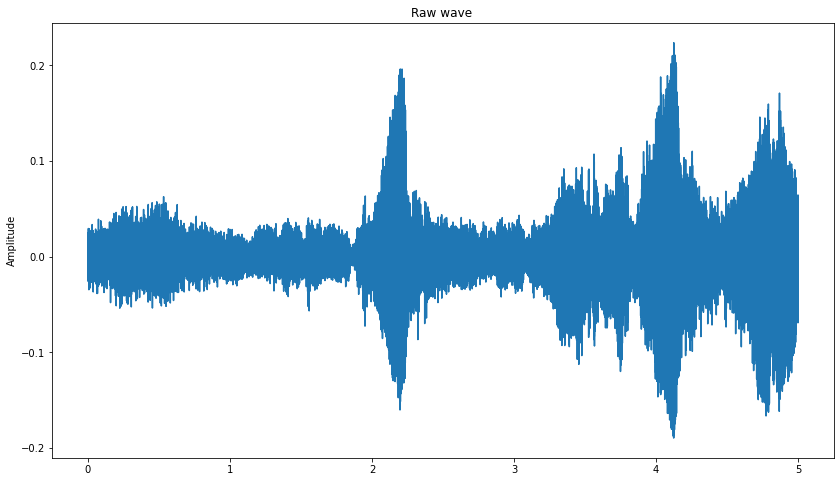

2 . Positive tag:  ['rock', 'woman', 'female vocal', 'female voice']


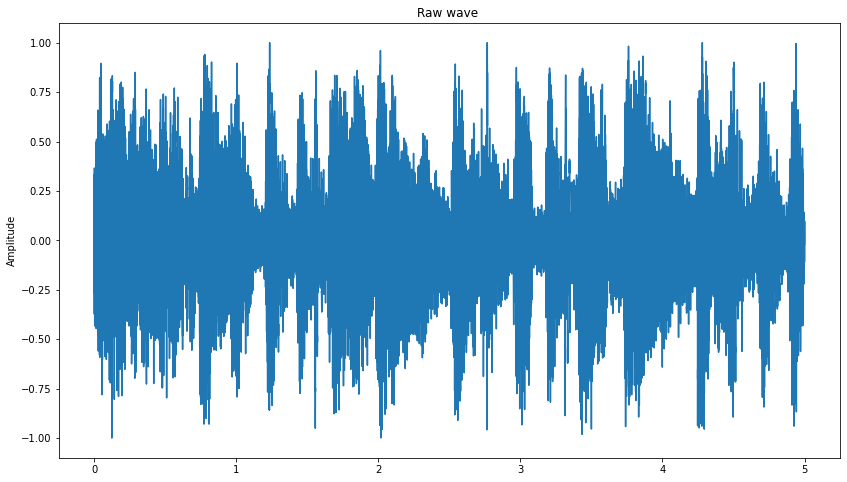

3 . Negative tag:  ['techno', 'fast', 'beat', 'synth']


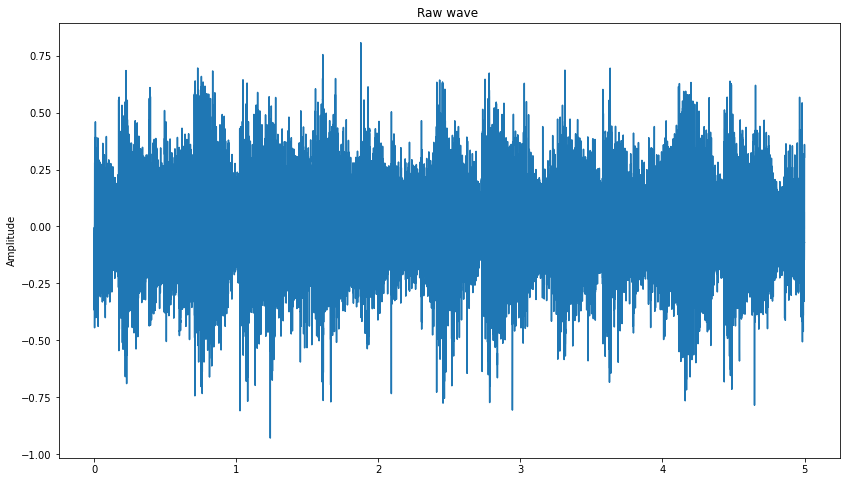

In [90]:
# Original tag-based random triplet
tag_binary = binary[tag]
positive_tracks = tag_binary[tag_binary != 0]
negative_tracks = tag_binary[tag_binary == 0]
anc_id, pos_id = positive_tracks.sample(2).index
anc_tag = get_tag_names(anc_id)
pos_tag = get_tag_names(pos_id)
neg_id = negative_tracks.sample(1).index[0]
neg_tag = get_tag_names(neg_id)

check_triplet_waveforms((anc_tag, anc_id), (pos_tag, pos_id), (neg_tag, neg_id))


### 2. Classifier Based Triplet

fn: tensor([ 2, 17, 40])  fp: tensor([13])
POS Changed to female vocal 42186
NEG Changed to vocal 47564
1 . Anchor tag:  ['classical', 'slow', 'violin', 'female', 'opera', 'woman', 'female vocal']


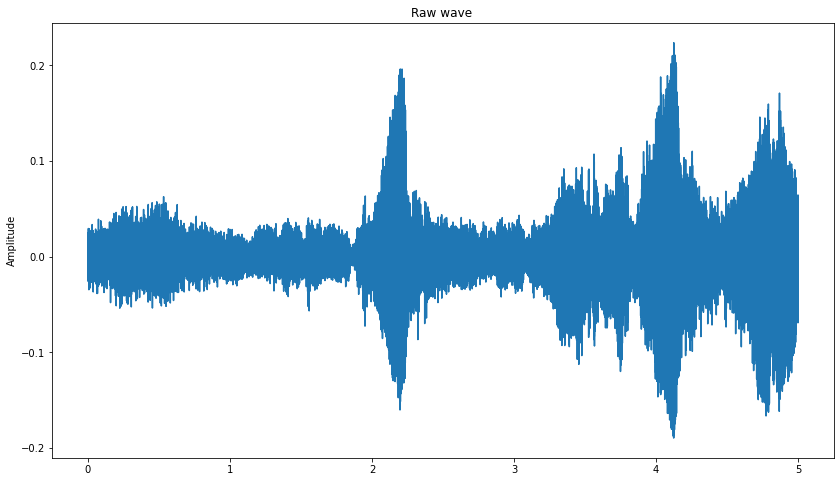

2 . Positive tag:  ['classical', 'strings', 'violin', 'female', 'singing', 'woman', 'female vocal']


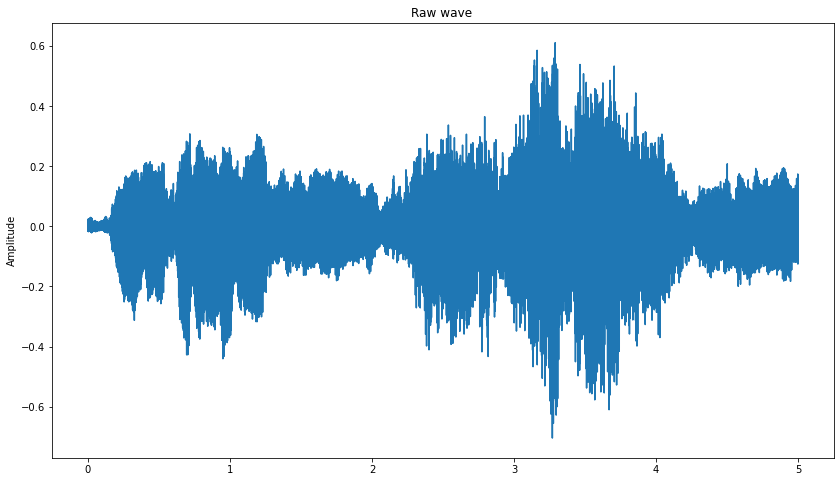

3 . Negative tag:  ['vocal', 'opera', 'choir', 'choral']


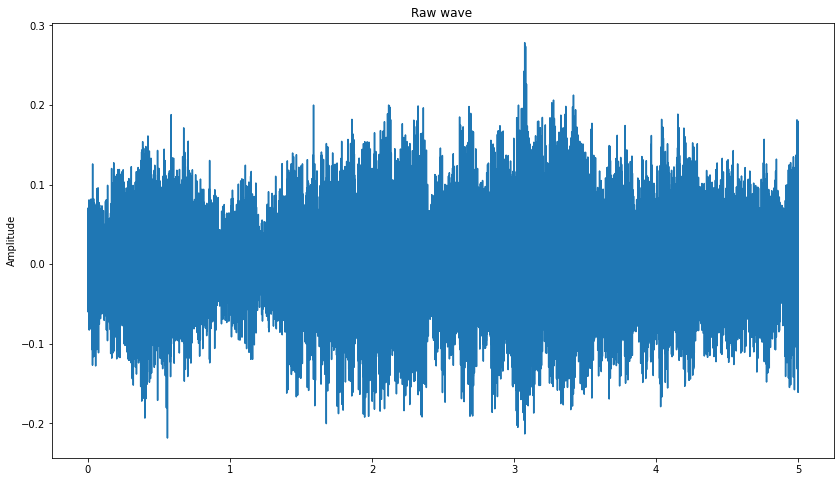

In [111]:
# classifier based triplet
anc_waveform = item_to_waveform(anc_id)
anc_spec = extract_spectograms(torch.tensor(anc_waveform).unsqueeze(0))
anc_spec = anc_spec.to(device)
anc_tags = torch.tensor(binary.loc[anc_id])

prediction = multi_tagging_model(anc_spec)
sorted_idx = torch.argsort(prediction).squeeze(0)
top_k = 5
top_k_idx = torch.flip(sorted_idx, [0])[1:top_k+1]
predicted_tags = (nn.functional.one_hot(top_k_idx, num_classes=50)).sum(dim=0).float()

score_note = anc_tags.cpu() - predicted_tags.cpu()
fn = (score_note==1).nonzero(as_tuple=True)[0]
fp = (score_note==-1).nonzero(as_tuple=True)[0]
print("fn:", fn, " fp:", fp)

if len(fn) != 0:
    pos_tag = tags[random.choice(fn).int()]
    pos_tag_binary = binary[pos_tag]
    pos_tracks = pos_tag_binary[pos_tag_binary == 1]
    pos_id = pos_tracks.sample(1).index[0]
    print("POS Changed to", pos_tag, pos_id)
if len(fp) != 0:
    neg_tag = tags[random.choice(fp).int()]
    neg_tag_binary = binary[neg_tag]
    neg_tracks = neg_tag_binary[neg_tag_binary == 1]
    neg_id = neg_tracks.sample(1).index[0]
    print("NEG Changed to", neg_tag, neg_id)
    
pos_tag = get_tag_names(pos_id)
neg_tag = get_tag_names(neg_id)
check_triplet_waveforms((anc_tag, anc_id), (pos_tag, pos_id), (neg_tag, neg_id))

## Suggested Triplet Dataset

In [116]:
import random

class TripletDataset(Dataset):
    def __init__(self, paths, id_to_path, input_length, binary, tags, split, classifier, top_k=0):
        """
        Args:
          paths (str): path to load dataset from
          id_to_path (Dict): track id to audio path
          input_length (int): sample_rate x duration (second) 
          binary (Pandas.DataFrame): binary matrix for audio (index: track_id, columns: tag binary)
          tags(list) : list of tag
          split (str): one of [TRAIN, VALID, TEST]
        """
        self.paths = paths
        self.id_to_path = id_to_path
        self.input_length = input_length
        self.tags = tags
        self.binary = binary
        self.split = split
        
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.classifier = classifier.to(self.device)
        self.top_k = top_k
        

    def __getitem__(self, index):
        if self.split in ["TRAIN","VALID"]:
            tag = random.choice(self.tags)
            tag_binary = self.binary[tag]
            positive_tracks = tag_binary[tag_binary != 0]
            negative_tracks = tag_binary[tag_binary == 0]
            anc_id, pos_id = positive_tracks.sample(2).index
            neg_id = negative_tracks.sample(1).index[0]
            
            anc_id = self.binary.sample(1).index[0]
            anc_waveform = self.item_to_waveform(anc_id)
            
            ##################################
            if self.top_k != 0:
                """
                [Classification Based Sampling]
                Positive Sample = Pick False Negative(FN) if it's exist.
                Negative Sample = Pick False Positive(FP) if it's exist.
                """
                anc_spec = extract_spectograms(torch.tensor(anc_waveform).unsqueeze(0))
                anc_spec = anc_spec.to(self.device)
                anc_tags = torch.tensor(self.binary.loc[anc_id])

                prediction = self.classifier(anc_spec)
                sorted_idx = torch.argsort(prediction).squeeze(0)
                top_k_idx = torch.flip(sorted_idx, [0])[1:self.top_k+1]
                predicted_tags = (nn.functional.one_hot(top_k_idx, num_classes=50)).sum(dim=0).float()

                score = anc_tags.cpu() - predicted_tags.cpu()
                fn = (score==1).nonzero(as_tuple=True)[0]
                fp = (score==-1).nonzero(as_tuple=True)[0]

                if len(fn) != 0:
                    pos_tag = tags[random.choice(fn).int()]
                    pos_tag_binary = self.binary[pos_tag]
                    pos_tracks = pos_tag_binary[pos_tag_binary == 1]
                    pos_id = pos_tracks.sample(1).index[0]
                if len(fp) != 0:
                    neg_tag = tags[random.choice(fp).int()]
                    neg_tag_binary = self.binary[neg_tag]
                    neg_tracks = neg_tag_binary[neg_tag_binary == 1]
                    neg_id = neg_tracks.sample(1).index[0]
            ##################################

            pos_waveform = self.item_to_waveform(pos_id)
            neg_waveform = self.item_to_waveform(neg_id)

            return anc_waveform, pos_waveform, neg_waveform

        elif self.split == "TEST":
            item = self.binary.iloc[index]
            id = item.name
            path = os.path.join(self.paths, self.id_to_path[id].replace(".mp3",".npy"))
            waveform = np.load(path)
            chunk_number = waveform.shape[0] // self.input_length
            chunk = np.zeros((chunk_number, self.input_length))
            for idx in range(chunk.shape[0]):
                chunk[idx] = waveform[idx * input_length:(idx+1) * input_length]
            audio = chunk.astype(np.float32)
            label = item.values.astype(np.float32)
            return audio, label

    def item_to_waveform(self, id):
        path = os.path.join(self.paths, self.id_to_path[id].replace(".mp3", ".npy")) # pre-extract waveform, for fast loader
        waveform = np.load(path)
        random_idx = np.random.randint(low=0, high=int(waveform.shape[0] - self.input_length))
        waveform = waveform[random_idx:random_idx+self.input_length] # extract input
        audio = np.expand_dims(waveform, axis = 0)# 1 x samples
        return audio.astype(np.float32)

    def __len__(self):
        if self.split in ["TRAIN","VALID"]:
            return len(self.binary) # it is tag wise sampling, so you can increase dataset length
        elif self.split == "TEST":
            return len(self.binary)

## Load data 

In [117]:
top_k=0

In [118]:
classifier = multi_tagging_model
tr_data = TripletDataset(data_path, id_to_path, input_length, df_train, TAGS, "TRAIN", classifier, top_k=top_k)
va_data = TripletDataset(data_path, id_to_path, input_length, df_valid, TAGS, "VALID", classifier, top_k=top_k)
te_data = TripletDataset(data_path, id_to_path, input_length, df_test, TAGS, "TEST", classifier)
loader_train = DataLoader(tr_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, drop_last=True)
loader_valid = DataLoader(va_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, drop_last=False)
loader_test = DataLoader(te_data, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

In [125]:
class Music_Embedding_Model(nn.Module):
    """
    Backbone model for linear proejction
    mel spectrogam to embedding
    """
    def __init__(self, feature_extractor, embedding_size=1024):
        """
        Args:
          sample_rate (int): path to load dataset from
          n_fft (int): number of samples for fft
          f_min (float): min freq
          f_max (float): max freq
          n_mels (float): number of mel bin
          n_class (int): number of class
        """
        super(Music_Embedding_Model, self).__init__()
        self.spec_bn = nn.BatchNorm2d(3)
        self.feature_extractor = feature_extractor
        self.linear = nn.Linear(3*4*256, embedding_size)
        
    def forward(self, x):
        x = self.spec_bn(x)
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        embedding = self.linear(x)
        return embedding

In [126]:
class Improved_Metric_Runner(object):
    def __init__(self, model, lr, momentum, weight_decay, sr):
        """
        Args:
          model (nn.Module): pytorch model
          lr (float): learning rate
          momentum (float): momentum
          weight_decay (float): weight_decay
          sr (float): stopping rate
        """
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.2, patience=5, verbose=True)
        self.learning_rate = lr
        self.stopping_rate = sr
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model = model.to(self.device)
        self.criterion = TripletLoss(margin=0.5).to(self.device)
        
    # Running model for train, test and validation. mode: 'train' for training, 'eval' for validation and test
    def run(self, dataloader, epoch, mode='TRAIN'):
        self.model.train() if mode is 'TRAIN' else self.model.eval()
        
        epoch_loss = 0
        pbar = tqdm(dataloader, desc=f'{mode} Epoch {epoch:02}')  # progress bar
        for item in pbar:
            # Move mini-batch to the desired device.
            anc, pos, neg = item
            anc = extract_spectograms(anc)
            pos = extract_spectograms(pos)
            neg = extract_spectograms(neg)
            anc_emb = self.model(anc.to(self.device))
            pos_emb = self.model(pos.to(self.device))
            neg_emb = self.model(neg.to(self.device))

            # Compute the loss.
            loss = self.criterion(anc_emb, pos_emb, neg_emb)
            if mode is 'TRAIN':
                # Perform backward propagation to compute gradients.
                loss.backward()
                # Update the parameters.
                self.optimizer.step()
                # Reset the computed gradients.
                self.optimizer.zero_grad()

            batch_size = anc_emb.shape[0]
            epoch_loss += batch_size * loss.item()
        epoch_loss = epoch_loss / len(dataloader.dataset)
        
        return epoch_loss
    
    def test(self, dataloader):
        self.model.eval()
        epoch_loss = 0
        embeddings, labels = [], []
        pbar = tqdm(dataloader, desc=f'TEST')  # progress bar
        for waveform, label in pbar:
            waveform = waveform.transpose(0, 1)
            waveform = extract_spectograms(waveform)
            with torch.no_grad():
                embedding = self.model(waveform.to(self.device))
            embeddings.append(embedding.mean(0,True).detach().cpu())
            labels.append(label)
        embeddings = torch.stack(embeddings).squeeze(1)
        labels = torch.stack(labels).squeeze(1)

        # calculate cosine similarity (if you use different distance metric, than you need to change this part)
        embedding_norm = embeddings / embeddings.norm(dim=-1, keepdim=True)
        sim_matrix = embedding_norm @ embedding_norm.T
        sim_matrix = sim_matrix.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        multilabel_recall = {
            "R@1" : self.multilabel_recall(sim_matrix, labels, top_k=1),
            "R@2" : self.multilabel_recall(sim_matrix, labels, top_k=2),
            "R@4" : self.multilabel_recall(sim_matrix, labels, top_k=4),
            "R@8" : self.multilabel_recall(sim_matrix, labels, top_k=8),
        }
        return multilabel_recall
    
    def multilabel_recall(self, sim_matrix, binary_labels, top_k):
        # =======================
        ## 
        data_num = len(sim_matrix)
        recall = 0
        for query_idx in range(data_num):
            query = sim_matrix[query_idx]
            sorted_idx = np.argsort(query)[::-1][1:top_k+1]
            y_q = binary_labels[query_idx]
            y_i = np.logical_or.reduce(([binary_labels[pred_idx] for pred_idx in sorted_idx]))
            recall += (np.sum(np.logical_and(y_q, y_i)) / np.sum(y_q))
        recall /= data_num
        return recall
        # =======================
        
    # Early stopping function for given validation loss
    def early_stop(self, loss, epoch):
        self.scheduler.step(loss, epoch)
        self.learning_rate = self.optimizer.param_groups[0]['lr']
        stop = self.learning_rate < self.stopping_rate
        return stop

In [158]:
LR = 1e-4
SR = 1e-5
MOMENTUM = 0.9
NUM_EPOCHS = 30
WEIGHT_DECAY = 1e-4

In [165]:
model = Music_Embedding_Model(music_feature_extractor)
runner = Improved_Metric_Runner(model=model, lr = LR, momentum = MOMENTUM, weight_decay = WEIGHT_DECAY, sr = SR)
for epoch in range(NUM_EPOCHS):
    train_loss = runner.run(loader_train, epoch, 'TRAIN')
    valid_loss = runner.run(loader_valid, epoch, 'VALID')
    print("[Epoch %d/%d] [Train Loss: %.4f] [Valid Loss: %.4f]" %(epoch + 1, NUM_EPOCHS, train_loss, valid_loss))
    if runner.early_stop(valid_loss, epoch + 1):
        break


[Epoch 1/15] [Train Loss: 0.1659] [Valid Loss: 0.2432]


In [166]:
multilabel_recall = runner.test(loader_test)

In [167]:
multilabel_recall

{'R@1': 0.47634560692813116,
 'R@2': 0.6166209464753155,
 'R@4': 0.7485045429220182,
 'R@8': 0.8455286622762342}

### Save & load

In [188]:
torch.save(multi_tagging_model, './music_embedding_model.pt')

PicklingError: Can't pickle <class '__main__.Multi_Tagging_Model'>: it's not the same object as __main__.Multi_Tagging_Model

In [22]:
multi_tagging_model = torch.load('./music_embedding_model.pt')


# Deliverables
You should submit your Python code (`.ipynb` or `.py` files) and homework report (.pdf file) to KLMS. The report should include:
* Algorithm Description
* Experiments and Results
* Discussion

# Note
The code is written using PyTorch but you can use TensorFlow if you want.

# Credit
Thie homework was implemented by Jongpil Lee, Soonbeom Choi, Taejun Kim and SeungHeon Doh in the KAIST Music and Audio Computing Lab.
